
## Problem Statement : 
To scrape the data of posts made from website **https://news.ycombinator.com/news**:
####  Create data frame of the posts with url,title,name of writer,domain ,date posted
####  For each url extract data and perform topic modelling 


### importing the libraries to work with the data

In [2]:
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import random
random.seed(124)

import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
# importing the soupstrainer parsing specified tags 
from bs4 import SoupStrainer

### Created five empty lists
1. tt-To store the title of the posts 
2. names- To store the url
3. usn- To store the name of the user 
4. dd- to store the names of the domain
5. to - to store the time at which the post was made 

## Working of loop::
- It will run for fifteen times with each number of the iteration will be added to the url by string so that pages can be
traversed.
- We will parse by 'td' and four variables are created to store the information of different tags
- Inner for loops will run for each four variable and the extracted information will be added to the created empty lists


In [125]:
tt=[]
names=[]
usn=[]
dd=[]
to=[]
for i in range(1,15):
    url="https://news.ycombinator.com/news?p="
    html=requests.get(url+str(i)).text
    soup = BeautifulSoup(html, 'html.parser',parse_only=SoupStrainer('td'))
    counter_title_url=soup.find_all('a',{'class':'storylink'})
    user=soup.find_all('a',{'class':'hnuser'})
    domain=soup.find_all('span',{'class':'sitestr'})
    time=soup.find_all('span',{'class':'age'})
    for i in counter_title_url:
         names.append(i['href'])
         tt.append(i.text.strip())
    for i in user:
        usn.append(i.text.strip())
    for i in domain:
        dd.append(i.text.strip())
    for j in time:
        to.append(j.text.strip())
    
        
    

## Working for extraction of the date
- The list of time('to')created contains time as (5 hours ago,2 weeks ago etc)
- We will slice the elements of list to extract number and the string (hours,weeks,day etc)
- Using the conditions based on hours , weeks etc we will create date and time using timedelta

In [129]:
from datetime import datetime, timedelta
date=[]
for i in to:
    time=i.split(" ")[1]
    number=int(i.split(" ")[0])
    
    if  (time == 'seconds'):
          date.append((datetime.now()-timedelta(seconds=number)).strftime('%Y-%m-%d %H:%M:%S'))
    elif  (time == 'minutes'):
          date.append((datetime.now()-timedelta(minutes=number)).strftime('%Y-%m-%d %H:%M:%S'))
    elif (time == 'hours'):
          date.append((datetime.now()-timedelta(hours=number)).strftime('%Y-%m-%d %H:%M:%S'))
    elif (time == 'days'):
          date.append((datetime.now()-timedelta(days=number)).strftime('%Y-%m-%d %H:%M:%S'))
    else :
          date.append((datetime.now()-timedelta(weeks=number)).strftime('%Y-%m-%d %H:%M:%S'))

## creating pandas series of the lists for creating a dataframe

In [139]:
title=pd.Series(tt)
url=pd.Series(names)
username=pd.Series(usn)
domainname=pd.Series(dd)
time_created=pd.Series(date)

In [140]:
#creating the dataframe
topic=pd.DataFrame({'Title':title,'posted_by_user':username,'Url':url,'Domain':domainname,'date_created':time_created})

In [142]:
# seeing the portion of the data
topic.head(5)
    

,Title,posted_by_user,Url,Domain,date_created
0,Almost everything on computers is perceptually...,zdw,https://threadreaderapp.com/thread/92759346064...,threadreaderapp.com,2019-12-19 20:34:41
1,How Shopify Manages API Versioning and Breakin...,tomnewton,https://engineering.shopify.com/blogs/engineer...,shopify.com,2019-12-19 19:04:41
2,The Amazon Premium,elorant,http://calpaterson.com/amazon-premium.html,calpaterson.com,2019-12-19 20:28:41
3,YouTube Created a Generation of Young Stars. N...,JumpCrisscross,https://www.wsj.com/articles/youtube-created-a...,wsj.com,2019-12-19 20:23:41
4,Building a new Windows 3.1 app in 2019: A Slac...,yeokm1,http://yeokhengmeng.com/2019/12/building-a-new...,yeokhengmeng.com,2019-12-19 10:04:41


### Extracting the text by going through the url of each of the post

In [174]:
for rownum, blog in topic.iterrows() :

    try:

        soup = BeautifulSoup(requests.get(blog['Url']).text, 'html.parser')

        if soup.head is not None : soup.head.decompose()

        # Navigations in the side
        for nav in soup.find_all('div', id = re.compile(".*[nav].$")):
            nav.decompose()

        # Selecting all the paragraphs
        text_data = ""

        for text in soup.find_all('p') :

            if text.form is not None : text.form.decompose()
            if text.a is not None : text.a.decompose()

            if not 'copyright' in text.text.lower() :
                text_data = text_data + " " + text.text

        topic.loc[rownum, 'Text'] = text_data.strip().lower() 
    
    except :
        pass

In [180]:
#cleaning the data frane by removing the rows which do not have any text
topic = topic[topic['Text'] != '']
topic.shape

(338, 6)

In [182]:
# seeing the dataframe
topic.head(5)

,Title,posted_by_user,Url,Domain,date_created,Text
0,Almost everything on computers is perceptually...,zdw,https://threadreaderapp.com/thread/92759346064...,threadreaderapp.com,2019-12-19 20:34:41,"12,399 views get real-time email alerts when ..."
1,How Shopify Manages API Versioning and Breakin...,tomnewton,https://engineering.shopify.com/blogs/engineer...,shopify.com,2019-12-19 19:04:41,earlier this year i took the train from ottawa...
2,The Amazon Premium,elorant,http://calpaterson.com/amazon-premium.html,calpaterson.com,2019-12-19 20:28:41,cal paterson |\n december 2019 how the bigges...
3,YouTube Created a Generation of Young Stars. N...,JumpCrisscross,https://www.wsj.com/articles/youtube-created-a...,wsj.com,2019-12-19 20:23:41,"december 19, 2019 the latest trend among youtu..."
4,Building a new Windows 3.1 app in 2019: A Slac...,yeokm1,http://yeokhengmeng.com/2019/12/building-a-new...,yeokhengmeng.com,2019-12-19 10:04:41,"in october 2019, my company sp digital held an..."


## Saving the data to a csv file to use incase the html page is not available for scraping 

In [181]:
topic.columns

Index(['Title', 'posted_by_user', 'Url', 'Domain', 'date_created', 'Text'], dtype='object')

In [183]:
topic.to_csv("TOPICS.csv", sep = ',', columns =['Title', 'posted_by_user', 'Url', 'Domain', 'date_created', 'Text'], header = True, index = False)

In [184]:
#creating a copy of my dataframe
topic_copy=topic.copy()

In [256]:
topic.shape

(338, 6)

In [257]:
topic.isnull().sum(axis=0) 

Title              0
posted_by_user     0
Url                0
Domain            18
date_created       0
Text              23
dtype: int64

In [258]:
#dropping na values as it is not useful and checking the shape again
topic.dropna(inplace=True)

In [259]:
topic.shape

(300, 6)

## TEXT PRE-PROCESSING
- Expand contradiction

In [260]:
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [261]:
def expand_contractions(text):
    for word in text.split():
        if word in contractions:
            text = text.replace(word, contractions[word])
    return text

In [262]:
## replacing words
topic['Text'] = [expand_contractions(re.sub('’', "'", text)) for text in topic['Text']]

## Removing accented characters

In [263]:
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [264]:
topic['Text'] = [remove_accented_chars(text) for text in topic['Text']]

# Scrub words

In [265]:
import string

def scrub_words(text):
    
    # Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    # Remove html markup if any
    text = re.sub("<.*?>", ' ', text)
    
    # Remove Punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra spaces from the text
    text = re.sub("\s+", ' ', text)
    
    return text

In [266]:
topic['Text'] = [scrub_words(text) for text in topic['Text']]

In [267]:
topic['Word_Count'] = [len(text.split(' ')) for text in topic['Text']]

In [268]:
topic.head(5)

,Title,posted_by_user,Url,Domain,date_created,Text,Word_Count
0,Almost everything on computers is perceptually...,zdw,https://threadreaderapp.com/thread/92759346064...,threadreaderapp.com,2019-12-19 20:34:41,12399 views get realtime email alerts when new...,125
1,How Shopify Manages API Versioning and Breakin...,tomnewton,https://engineering.shopify.com/blogs/engineer...,shopify.com,2019-12-19 19:04:41,earlier this year i took the train from ottawa...,1379
2,The Amazon Premium,elorant,http://calpaterson.com/amazon-premium.html,calpaterson.com,2019-12-19 20:28:41,cal paterson december 2019 how the biggest clo...,966
3,YouTube Created a Generation of Young Stars. N...,JumpCrisscross,https://www.wsj.com/articles/youtube-created-a...,wsj.com,2019-12-19 20:23:41,december 19 2019 the latest trend among youtub...,61
4,Building a new Windows 3.1 app in 2019: A Slac...,yeokm1,http://yeokhengmeng.com/2019/12/building-a-new...,yeokhengmeng.com,2019-12-19 10:04:41,in october 2019 my company sp digital held an ...,2408


In [291]:
topic[topic.Word_Count>1000000].shape

(1, 8)

In [269]:
## Getting the first quartile value
q1 = np.percentile(topic.Word_Count, 25)

print('The first quartile value of words_count attribute is', q1)

The first quartile value of words_count attribute is 121.5


In [270]:
topic = topic[topic.Word_Count > q1]
topic.reset_index(drop = True, inplace = True)
topic.shape

(225, 7)

## As spacy can handle only words upto ten lakh so i am dropping the row which is greater than ten lakh

In [294]:
topic=topic[topic.Word_Count<1000000]
topic.reset_index(drop = True, inplace = True)
topic.shape

(224, 8)

## Libraries for removing stop words and performing lemmatisation

In [271]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [274]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [298]:
# function for tokenisation and lemmatisation
def preprocess(doc):
    tokens = [word.text for word in doc if not word.is_stop]
    filtered_tokens = []
    for token in tokens:
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        if re.search('[a-zA-Z]', token):
            token = lemmatizer.lemmatize(token)
            filtered_tokens.append(token)
    return filtered_tokens      

In [299]:
# created lematised text column in the data frame
topic['clean_text_lemmatized'] = np.nan
topic['clean_text_lemmatized'] = topic['clean_text_lemmatized'].astype(object)
vocab_lemmatized = []
for idx in range(len(topic)) :

    doc = nlp(topic.Text[idx])
    words_lemmatized = preprocess(doc)
    vocab_lemmatized.extend(words_lemmatized)
    topic.at[idx, 'clean_text_lemmatized'] = words_lemmatized

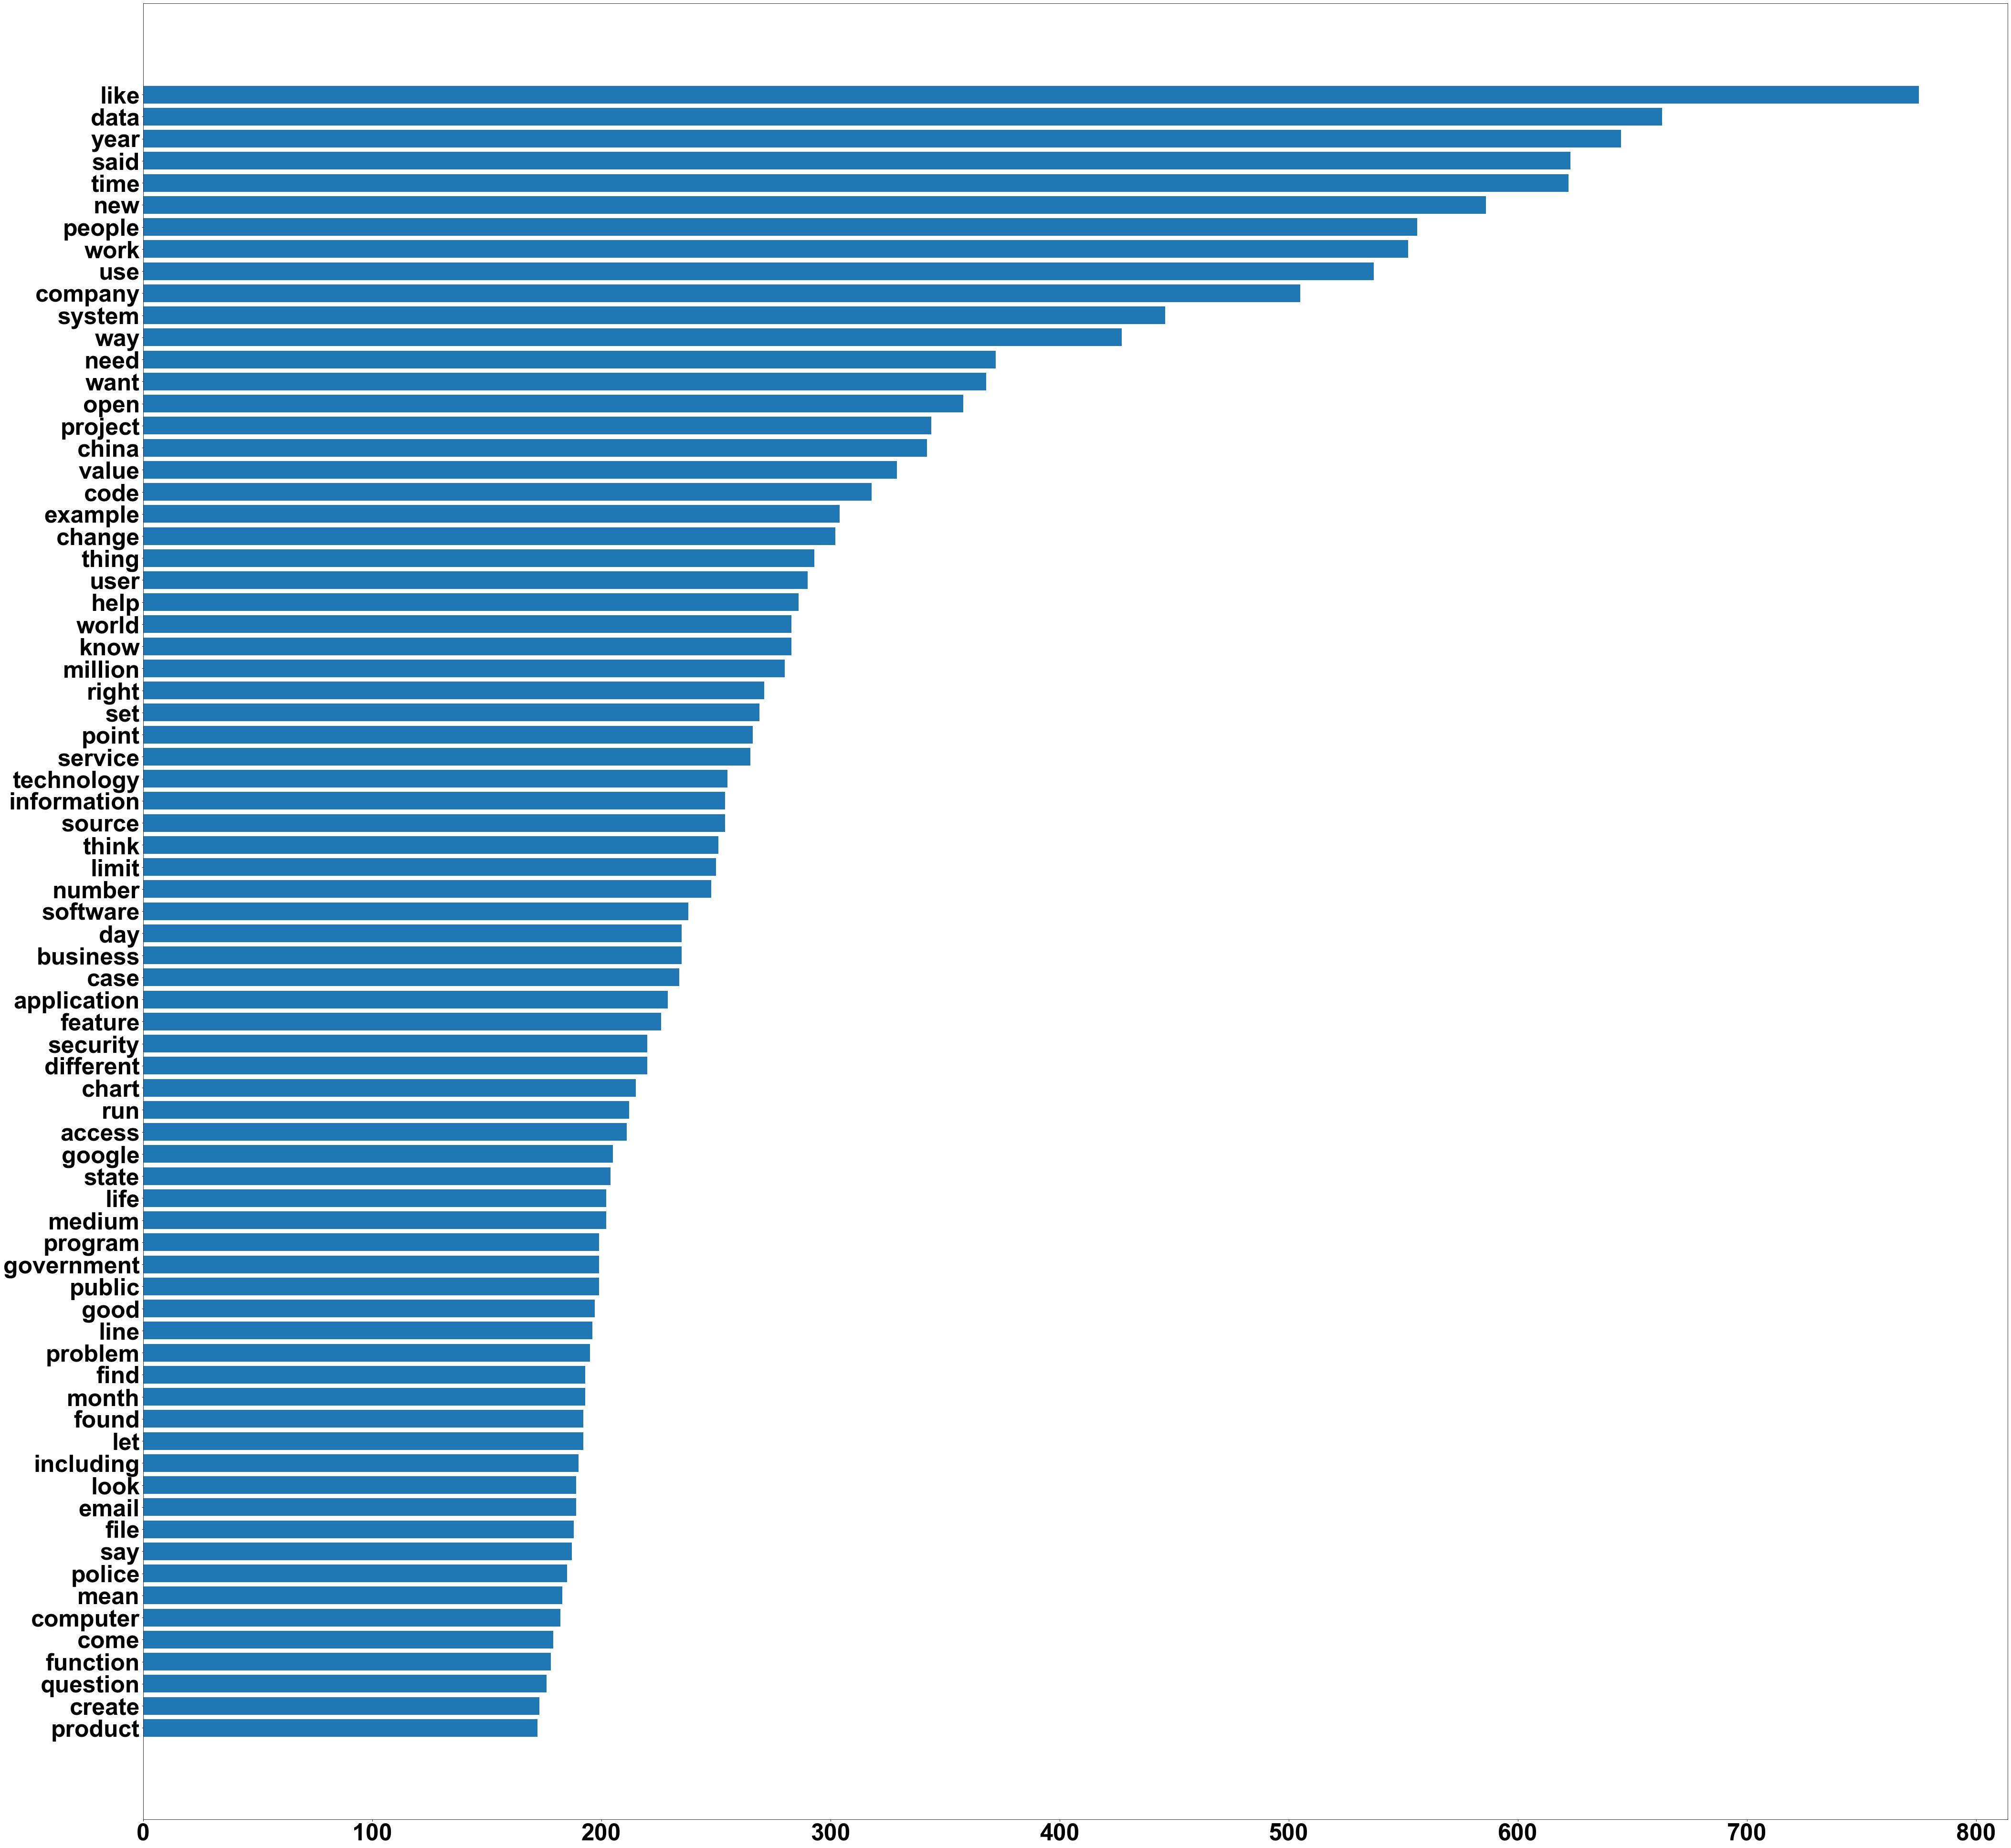

In [373]:
import matplotlib.pyplot as plt
%matplotlib inline
vocab_frame = pd.DataFrame({'words': vocab_lemmatized})
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 50}
values, counts = np.unique(vocab_frame, return_counts=True)

sorted_indices = np.argsort(-counts)


values = values[sorted_indices]
counts = counts[sorted_indices]
plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(values[:75], counts[:75])
plt.gca().invert_yaxis()
plt.show()

## Graph of the most frequent words in the whole corpus
- Tells a lot about the posts and the type of topics it covers

## TF-IDF

In [301]:
## tfidf vectorizer needs sentence and not token. Hence we need to combine all the tokens back to form a string
topic['clean_text_lemmatized'] = [' '.join(text) for text in topic['clean_text_lemmatized']]

- lemmatized text will be used 

In [302]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, max_features = 20000, min_df = 0.05, 
                                   use_idf = True, ngram_range = (1,4))

tfidf_matrix = tfidf_vectorizer.fit_transform(topic['clean_text_lemmatized'])
print(tfidf_matrix.shape)

(224, 1511)


## using SVD MODEL

In [303]:
from sklearn.decomposition import TruncatedSVD

n_components = 50

svd_model = TruncatedSVD(n_components=n_components, algorithm='randomized',n_iter=20,random_state=143)

svd_matrix = svd_model.fit(tfidf_matrix)

svd_matrix

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=20,
             random_state=143, tol=0.0)

## Seeing the few most important words in each topic

In [305]:
terms = tfidf_vectorizer.get_feature_names()
for i, comp in enumerate(svd_model.components_):
    print(f"The component is {comp} and shape is {comp.shape}")
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:6]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(f"{t[0]} -- {t[1]}")
    print(" ")

The component is [0.0208326  0.04145158 0.00883112 ... 0.01689153 0.02311587 0.0201363 ] and shape is (1511,)
Topic 0: 
said -- 0.16154319705657064
company -- 0.14347643227383933
data -- 0.1387600481452958
people -- 0.11955560738712687
like -- 0.11907296054436599
year -- 0.11617998946558032
 
The component is [-0.00702482 -0.01240846 -0.00424856 ... -0.00680719 -0.0114382
  0.00343535] and shape is (1511,)
Topic 1: 
tweet -- 0.5734142648187707
instantly -- 0.2400352759016599
instant -- 0.23408833016268005
add -- 0.2030137188489869
topic -- 0.18509626238151197
twitter -- 0.17833397169969128
 
The component is [-0.00029856  0.01412096 -0.01590858 ... -0.02424768 -0.03620878
 -0.01822488] and shape is (1511,)
Topic 2: 
file -- 0.1867849142444639
happens -- 0.15364830530799828
code -- 0.15291140740241851
try -- 0.13916609190771304
run -- 0.1271369624752285
function -- 0.12344359466284223
 
The component is [ 0.00173748 -0.01963727  0.00326194 ... -0.00842549 -0.02006645
 -0.02331161] and s

billion -- 0.1269245254038694
google -- 0.12073175220781862
 
The component is [-0.0047314  -0.02091823  0.00565103 ...  0.01042421  0.02633919
  0.06563363] and shape is (1511,)
Topic 27: 
health -- 0.1521891131848207
attack -- 0.15082950195796518
business -- 0.13991673373926639
hacker -- 0.13902113904814245
security -- 0.13173691282463237
network -- 0.11858202701575021
 
The component is [-0.00936931 -0.01836669 -0.00536147 ...  0.0052208   0.00147252
 -0.00633205] and shape is (1511,)
Topic 28: 
trust -- 0.2379688845049741
infrastructure -- 0.17183560285791558
user -- 0.1657808444465521
privacy -- 0.1436208216848319
city -- 0.13182463248176016
return -- 0.1233077260489091
 
The component is [-0.00278728  0.02566769  0.00252068 ...  0.02759356  0.00162711
 -0.12118564] and shape is (1511,)
Topic 29: 
app -- 0.1433838527896627
apple -- 0.1262678405334906
trust -- 0.12041431848036292
tool -- 0.11757725109148498
privacy -- 0.10611780617144899
company -- 0.10482999659075408
 
The compone

## Tagging each document with a topic 

In [306]:
doc_topic_matrix = svd_matrix.transform(tfidf_matrix)
print("\nDoc Topic Matrix: \n",doc_topic_matrix)
svd_categories = np.argmax(doc_topic_matrix, axis=1)
print("\nSVD Categories: \n",svd_categories)


Doc Topic Matrix: 
 [[ 0.19906057  0.20053847  0.05449747 ...  0.08449648  0.21327546
   0.02777286]
 [ 0.26872884 -0.03977489  0.12705871 ... -0.00990976 -0.03419489
   0.01017324]
 [ 0.27388434 -0.04454573  0.1226663  ... -0.13108029 -0.11046185
   0.0236666 ]
 ...
 [ 0.20699894 -0.0065079   0.18326921 ... -0.0269052   0.03793579
   0.00272422]
 [ 0.25866465 -0.03574482  0.04685572 ...  0.01063638  0.02130591
  -0.00838748]
 [ 0.19134912 -0.04978797  0.00130437 ... -0.1402498   0.12361128
  -0.14306148]]

SVD Categories: 
 [48  0 13  0  0  0  0  0  0  8  0 20  0  1  0  0  0  0  0 47 36  0  2  0
  0  0  0  0  0  0  0  0  2  0  0  0  0  0 11 49  0 28  3  2  9  0 26  0
 10  0 42  3 41  0  0  0  0  0  2  0  0  0  7  0  7  0  1 34  0  1  0  0
  0  2  3  0 31  0  0 37  2  4  0  3  6  0  0 25  8  0  1  0 39  0  0  0
 21 30  2  0  3  0  6 28  0  0  2  0 39  0  0  0 32  0  0  0 39 13  1  0
 45  2  0  0  0  0  0  0  7  0  0  0  4  0  0 36  0  0 23  0 39  3  0 30
  0 18 32  2 43  2  1  7 21  0

In [307]:
topic['SVD_group'] = svd_categories

## Performing k means clustering on document topic matrix

In [308]:
from sklearn import metrics
from sklearn.cluster import KMeans
import joblib
Sum_of_squared_distances = []

K = range(1,8)

for k in K:

    kmeanModel = KMeans(n_clusters=k, random_state=143)
    kmeanModel.fit(doc_topic_matrix)
    Sum_of_squared_distances.append(kmeanModel.inertia_)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


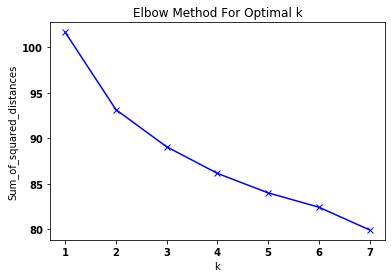

In [309]:
## Plotting the elbow curve
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 4 appears to be the most appropriate number of clusters that should be chosen

In [310]:
## printing the cluster centres
num_clusters = 4

km = KMeans(n_clusters=num_clusters)

km.fit(doc_topic_matrix)

clusters = km.labels_.tolist()

centers = km.cluster_centers_
print(f"the cluster centers are {centers}")

joblib.dump(km,  'doc_topic_cluster_best_K.pkl')

the cluster centers are [[ 2.79778459e-01  1.15827825e-02  3.20947100e-01  1.37404386e-01
  -1.13520161e-02 -8.36451435e-02  1.16408420e-01  7.23845807e-02
  -5.78950301e-02  9.86580149e-03 -2.07304528e-02 -1.56515962e-02
   2.36104201e-04  3.05163965e-02  6.62207683e-03 -1.39241785e-03
   1.07517151e-02 -6.25545285e-03 -1.46252552e-02 -1.17605402e-02
   4.69279051e-02 -2.95127686e-02 -1.01637291e-02  6.44411324e-03
   7.41488813e-03  1.63008315e-03 -3.05215507e-02  2.05421445e-03
  -1.35891109e-02 -1.69083482e-02  1.09933517e-02 -9.10544300e-03
  -3.87132290e-03 -1.61104945e-02 -1.91975176e-02 -9.49759132e-03
  -1.51104179e-02 -1.82094010e-02  2.49171640e-03 -1.46332202e-02
  -1.05240276e-05 -1.05991495e-02 -9.43495447e-03  2.49859161e-03
  -3.55176842e-03 -1.21936773e-02 -2.10105589e-02 -2.69498732e-03
   5.62104682e-03  2.26522584e-03]
 [ 2.65723064e-01  9.50803740e-01 -1.04056918e-01 -4.43615786e-03
  -1.29663936e-02 -1.75673741e-02 -5.62480476e-03  1.36525673e-02
   4.45611956e-03

['doc_topic_cluster_best_K.pkl']

In [311]:
## creating a column for the doc clusters
clusters = km.labels_.tolist()
topic['doc_topic_cluster_group'] = clusters

In [312]:
doc_cluster_df = topic
doc_cluster_df['doc_topic_cluster_group'].value_counts()

3    138
2     58
0     19
1      9
Name: doc_topic_cluster_group, dtype: int64

## Getting most important word in each cluster

In [313]:
doc_cluster_df['tokenized_text'] = [text.split(' ') for text in doc_cluster_df['clean_text_lemmatized']]

In [315]:
grouped_text = doc_cluster_df.groupby('doc_topic_cluster_group')['tokenized_text']

In [316]:
frequent_words_df = pd.DataFrame(columns={"values", "counts", "cluster_id"})

In [318]:
from itertools import chain
for num in range(num_clusters):
    values, counts = np.unique(list(chain.from_iterable(grouped_text.get_group(num))), return_counts=True)
    sorted_indices = np.argsort(-counts)
    frequent_words_df = frequent_words_df.append({"values":values[sorted_indices], "counts":counts[sorted_indices], "cluster_id": num}, ignore_index=True)

In [319]:
frequent_words_df.head()

,values,cluster_id,counts
0,"[value, use, feature, file, nullish, new, b, d...",0,"[167, 151, 119, 105, 105, 95, 92, 91, 88, 88, ..."
1,"[tweet, add, website, location, instant, insta...",1,"[64, 36, 27, 27, 27, 27, 27, 27, 18, 18, 18, 1..."
2,"[said, year, company, china, people, data, tim...",2,"[469, 349, 308, 305, 229, 223, 187, 166, 166, ..."
3,"[like, time, data, work, new, people, open, pr...",3,"[547, 380, 377, 366, 353, 308, 307, 297, 292, ..."


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


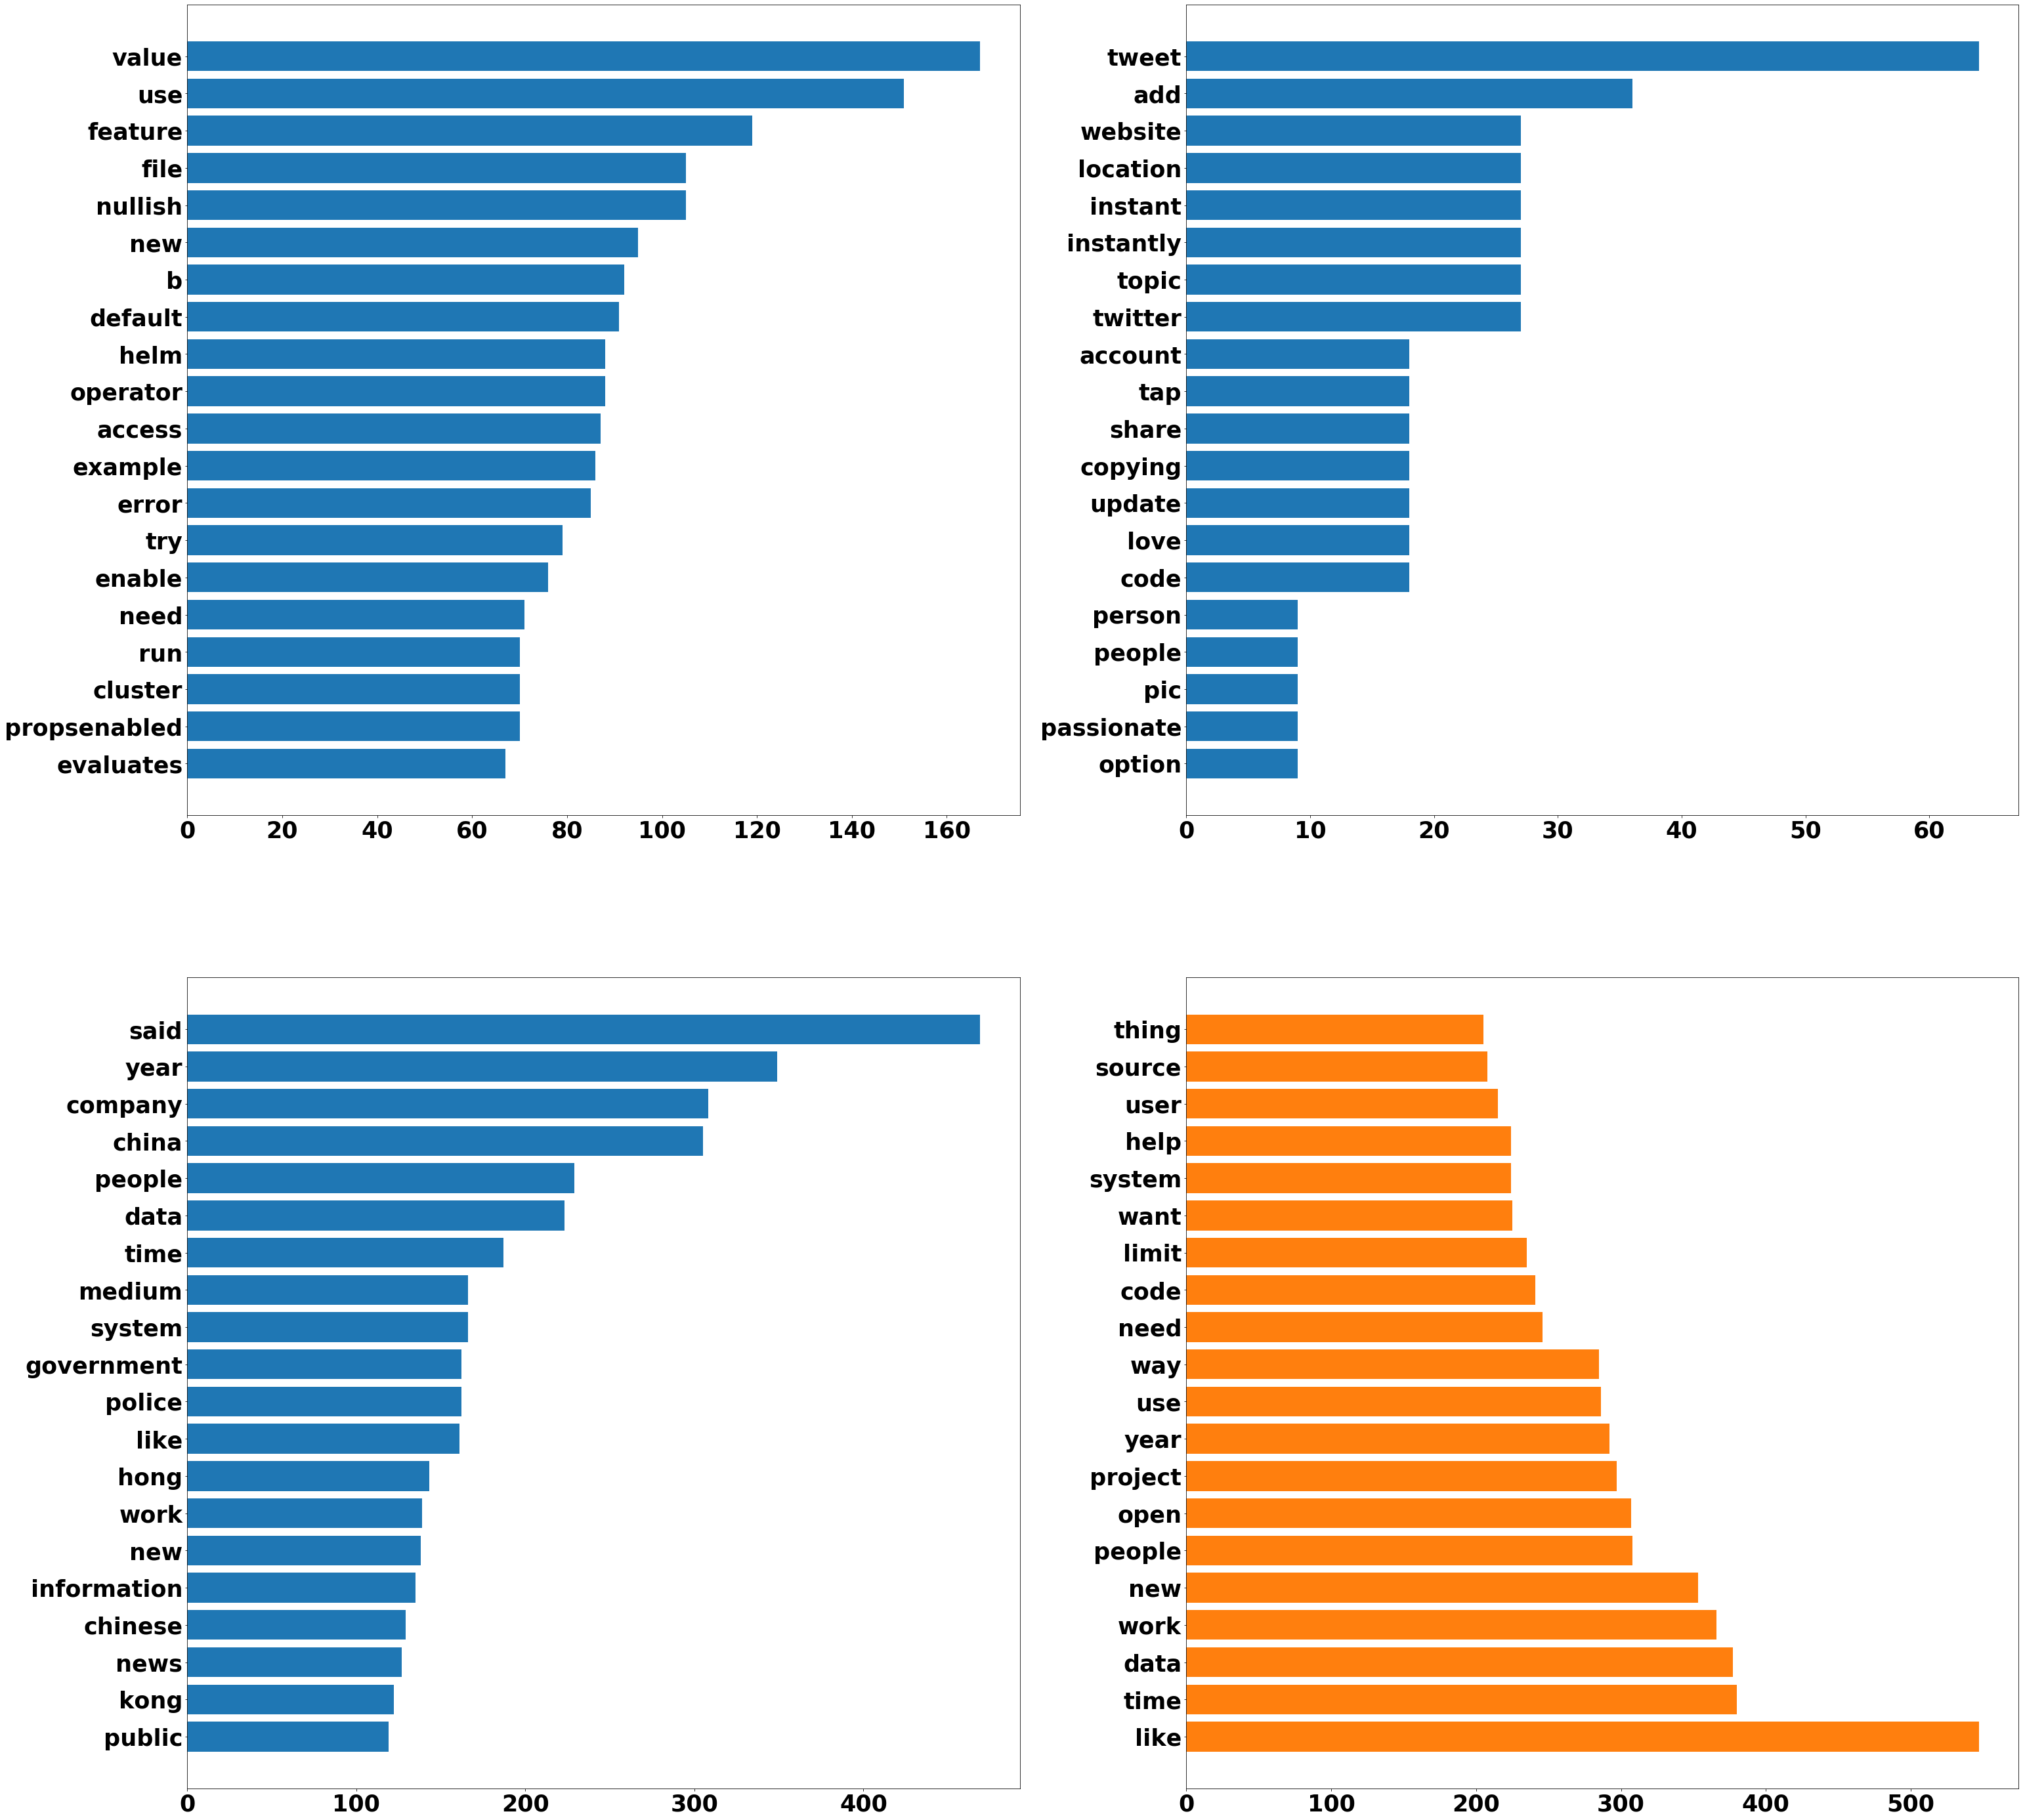

In [320]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 35}

plt.rc('font', **font)

fig = plt.figure(figsize=(50,50))
plt.subplot(2,2,1)
plt.barh(frequent_words_df.loc[0,'values'][:20], frequent_words_df.loc[0,'counts'][:20])
plt.gca().invert_yaxis()


plt.subplot(2,2,2)
plt.barh(frequent_words_df.loc[1,'values'][:20], frequent_words_df.loc[1,'counts'][:20])
plt.gca().invert_yaxis()

plt.subplot(2,2,3)
plt.barh(frequent_words_df.loc[2,'values'][:20], frequent_words_df.loc[2,'counts'][:20])
plt.gca().invert_yaxis()
plt.subplot(2,2,4)
plt.barh(frequent_words_df.loc[3,'values'][:20], frequent_words_df.loc[3,'counts'][:20])
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.barh(frequent_words_df.loc[3,'values'][:20], frequent_words_df.loc[3,'counts'][:20])
plt.gca().invert_yaxis()

## From the different distribution of words in the cluster we can say
1.  may be containing topics related to description of various products 
2. shows topics about twitter other websites 
3. shows maybe topics related to china and its conditions
4. shows maybe topics related to data science or other technical projects 

In [322]:
## grouping by cluster group
topic.groupby(['doc_topic_cluster_group', 'Title']).count().Text

doc_topic_cluster_group  Title                                                                           
0                        A Virtualized Raspberry Pi Inside a Docker Image                                    1
                         A programming language in ancient Chinese text                                      1
                         An opinionated approach to GNU Make                                                 1
                         Helm 3 Is Almost Boring but Mature                                                  1
                         Kubernetes Federation v2 in Action                                                  1
                         Linux Fu: Stupid SSH Tricks                                                         1
                         Practical Introduction to Prometheus for Developers                                 1
                         Show HN: Open-Source WordPress Infrastructure on Kubernetes                         1
      

## Topics name that can be said by looking at the clusters

### CLUSTER 0  =  *TECHNOLOGY*
### CLUSTER 1  =  *COMPUTER SCIENCE*
### CLUSTER 2  =  *BUSINESS AND POLITICS*
### CLUSTER 3  =  *CURRENT AFFAIRS*

In [372]:
l=['TECHNOLOGY', 'COMPUTER SCIENCE', 'BUSINESS AND POLITICS', 'CURRENT AFFAIRS']
for i in range(0,4):
    print("Top articles for cluster {} and topic {}".format(i,l[i]))
    print(topic[topic.doc_topic_cluster_group==i]['Title'].head(3))

Top articles for cluster 0 and topic TECHNOLOGY
11             Undocumented Catalina file access change
22                                      V8 Release v8.0
32    Show HN: Ordinary Puzzles – An open-source mob...
Name: Title, dtype: object
Top articles for cluster 1 and topic COMPUTER SCIENCE
13    Almost everything on computers is perceptually...
66    ARM64 CPUs speculatively execute instructions ...
69    Google claims copyright on employee side projects
Name: Title, dtype: object
Top articles for cluster 2 and topic BUSINESS AND POLITICS
6     Contractor pleads guilty to planting logic bom...
8     An investigation into the smartphone tracking ...
12    Depression and suicide linked to air pollution...
Name: Title, dtype: object
Top articles for cluster 3 and topic CURRENT AFFAIRS
0    Almost everything on computers is perceptually...
1    How Shopify Manages API Versioning and Breakin...
2                                   The Amazon Premium
Name: Title, dtype: object
